# OCR Model for Captchas
##### @ AIMedic<br>
##### Author: Shahryar Namdari



## Importing Libraries

In [1]:
import os
from math import sqrt,floor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Connect to Google Drive

In [51]:
# # Load the Drive helper and mount
# from google.colab import drive
# drive.mount('/content/drive')

## CTCLayer Class
Link to CTC Layer explanation:<br>
https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c

In [9]:
class CTCLayer(layers.Layer):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.loss_fn = keras.backend.ctc_batch_cost

  def call(self, y_true, y_pred):
    '''
      getting y_true and y_pred
      calculating ctc loss and adding to model while training
      and finally returning y_pred wthout changing it
    '''
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss)
    return y_pred

## OCR Captcha Class

In [42]:
class OCR_Captcha():
  '''
    Cotaining methods for:
    loading data, preprocessing, building model and training model
    Also, loaded data and other variables will be able inside an instance of this class
  '''
  def __init__(self, img_width, img_height, label_length):
    self.img_width = img_width
    self.img_height = img_height
    self.label_length = label_length #length of captchas labels

    #dataset
    self.images = None
    self.labels = None

    #encoding labels to numbers and then decoding them
    self.char_to_num = None 
    self.num_to_char = None

    #all characters inside all labels.
    #used as a vocabulary in char_to_num and num_to_char
    self.characters = None
    
    #dataset splitted
    self.x_train = None
    self.x_valid = None
    self.x_test = None
    self.y_train = None
    self.y_valid = None
    self.y_test = None

    #model
    self.model = None
    self.history = None

  def load_dataset(self, path:str):
    '''
      getting path to dataset folder which contains all images
      reading .png images, its labels and all characters used in labels
      saving these variables in a OCR_Captcha class
    '''
    data_dir = Path(path)
    self.images = sorted(list(map(str, list(data_dir.glob("*.png")))))
    self.labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in self.images]
    characters = set(char for label in self.labels for char in label)
    self.characters = sorted(list(characters))

  def split_data(self, shuffle:bool=True) -> \
  tuple([np.ndarray,np.ndarray,np.ndarray,np.ndarray,np.ndarray,np.ndarray]):
    '''
      split data into:
      train, validation and test
      and then returning them
    '''
    x_train, x_valid, y_train, y_valid = train_test_split(
        np.array(self.images), np.array(self.labels), test_size=0.2, shuffle=shuffle)
    x_valid, x_test, y_valid, y_test = train_test_split(
        x_valid, y_valid, test_size=0.5, shuffle=shuffle)
    return x_train, y_train, x_valid, y_valid, x_test, y_test

  def pre_process_and_create_dataset(self):
    '''
      defining char_to_num and num_to_char for encoding and decoding labels
      splitting and encoding dataset
      saving dataset into the class variables
    '''
    self.char_to_num = layers.StringLookup(vocabulary=list(self.characters))
    self.num_to_char = layers.StringLookup(vocabulary=self.char_to_num.get_vocabulary(), invert=True)
    x_train, y_train, x_valid, y_valid, x_test, y_test = self.split_data()
    self.x_train, self.y_train = self.encode_dataset(x_train, y_train)
    self.x_valid, self.y_valid = self.encode_dataset(x_valid, y_valid)
    self.x_test, self.y_test = self.encode_dataset(x_test, y_test)

  def encode_dataset(self, x_dataset:np.ndarray, y_dataset:np.ndarray) -> tuple([list, list]):
    '''
      do preprocessing on dataset:
        1.preprocessing images
        2.encoding labels
      and finally returning them
    '''
    images = []
    labels = []
    for i in range(len(x_dataset)):
      img = cv2.imread(x_dataset[i], 0)
      img = cv2.transpose(img)
      img = img.astype(np.float32)
      img /= 255
      img = np.resize(img, (self.img_width, self.img_height, 1))
      images.append(img)
      label = [x for x in y_dataset[i]]
      label = np.array(self.char_to_num(tf.constant(label)))
      labels.append(label)
    return images, labels

  def decode_array_to_string(self, num:np.ndarray) -> str:
    '''
      getting an array which is encoded into numbers
      and decoding it into a label and returning it
    '''
    decoded = ''
    s = self.num_to_char(num).numpy()
    for i in range(self.label_length):
      decoded += s[i].decode("utf-8")
    return decoded

  def build_model(self):
    '''
      building a functional model with Conv2D, Dense and LSTM layers
      for calculating ctc loss the model gets two inputs:
        1.images
        2.labels
      finally returning the model
    '''
    input1 = keras.Input(shape=(self.img_width, self.img_height, 1),
                            name="input_image", dtype="float32")
    input2 = layers.Input(shape=(None,), dtype="float32")

    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input1)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Reshape(((int(self.img_width/4)), (int(self.img_height/4))*32))(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(len(self.char_to_num.get_vocabulary())+1,
                      activation="softmax", name ="output_dense")(x)
    output = CTCLayer()(input2, x)
    model = keras.models.Model(inputs=[input1, input2], outputs=output)
    model.compile(optimizer=keras.optimizers.Adam())
    return model

  def build_and_train_model(self, epochs:int, early_stop:int,
                            restore_best_weights:bool, batch_size:int, shuffle:bool=True):
    '''
      Building and training the model
      The training process contains "early stop" to avoid overfitting
      training variables are taken as parameters in this function
    '''
    self.model = self.build_model()
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=early_stop,
          restore_best_weights=restore_best_weights, verbose=True)
    
    self.history = self.model.fit(
        x = [tf.stack(self.x_train), tf.stack(self.y_train)],
        y = tf.stack(self.y_train),
        validation_data=([tf.stack(self.x_valid), tf.stack(self.y_valid)], tf.stack(self.y_valid)),
        epochs=epochs,
        batch_size = batch_size,
        shuffle = shuffle,
        callbacks=[early_stopping])

## Evaluation Class

In [45]:
class Evaluation():
  '''
    A class which uses an instance from OCR_Captcha class to evaluate it
    this evaluation contains output files like accuracy, loss, model summary
    and sample visualization of images and labels
    output files will be saved in a directory of the code
  '''
  def __init__(self, OCR_Model):
    #varibales are from OCR_Captcha class which defined before
    self.model = OCR_Model.model
    self.history = OCR_Model.history
    self.x_test = OCR_Model.x_test
    self.y_test = OCR_Model.y_test
    self.num_to_char = OCR_Model.num_to_char
    self.label_length = OCR_Model.label_length
    self.x_train = OCR_Model.x_train
    self.y_train = OCR_Model.y_train
    self.img_width = OCR_Model.img_width
    self.img_height = OCR_Model.img_height

    #predicted_data is a list of 4 other lists
    #that contain correct and wrong predicted images and labels
    self.predicted_data = None

  def decode_array_to_string(self, num:np.ndarray) -> str:
    '''
      getting an array which is encoded into numbers
      and decoding it into a label and returning it
    '''
    decoded = ''
    s = self.num_to_char(num).numpy()
    for i in range(self.label_length):
      decoded += s[i].decode("utf-8")
    return decoded

  def decode_predictions(self, preds:np.ndarray) -> list:
    '''
      get predicted labels which is the output of "prediction_model"
      then decoding them into strings
      finally returning all the strings as a list
    '''
    input_len = np.ones(preds.shape[0]) * preds.shape[1]
    results = keras.backend.ctc_decode(preds, input_length=input_len, greedy=True)[0][0][
        :, :self.label_length]
    output_text = []
    for res in results:
        output_text.append(self.decode_array_to_string(res))
    return output_text

  def save_model_summary(self, prediction_model):
    '''
      saving the summary of prediction_model in a .txt file
    '''
    if os.path.exists("model_summary.txt"):
      os.remove("model_summary.txt")
    def myprint(s):
      with open('model_summary.txt','a') as f:
          print(s, file=f)
    prediction_model.summary(print_fn=myprint)

  def save_model_loss(self):
    '''
      saving the figure of train and validation loss in a .png file
    '''
    pd.DataFrame(self.history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.savefig('model_loss.png')

  def create_predicted_data(self, wrongly_predicted:list, preds_labels:list):
    '''
      getting indices(wrongly_predicted) of wrongly predicted data
      creating and saving a "predicted_data" which is a list of 4 other lists
      that are correct and wrong predicted images and labels
    '''
    x_wrong_predicted = []
    y_wrong_predicted = []
    x_correct_predicted = []
    y_correct_predicted = []
    for i in range(len(self.x_test)):
      if i in wrongly_predicted:
        x_wrong_predicted.append(self.x_test[i])
        y_wrong_predicted.append(preds_labels[i])
      else:
        x_correct_predicted.append(self.x_test[i])
        y_correct_predicted.append(preds_labels[i])
    self.predicted_data = [x_wrong_predicted, y_wrong_predicted,
                           x_correct_predicted, y_correct_predicted]

  def save_model_accuracy(self, prediction_model):
    '''
      predicting labels
      calculating and saving model accuracy in a .txt file
    '''
    true_predicted_num = 0
    test_size = len(self.y_test)
    preds = prediction_model.predict(tf.stack(self.x_test))
    preds_labels = self.decode_predictions(preds)
    orig_texts = []
    wrongly_predicted = []
    for j in range(len(self.y_test)):
      label = self.decode_array_to_string(self.y_test[j])
      orig_texts.append(label)
    for i in range(len(self.x_test)):
      if preds_labels[i]==orig_texts[i]:
        true_predicted_num+=1
        wrongly_predicted.append(i)
    self.create_predicted_data(wrongly_predicted, preds_labels)
    with open('model_accuracy.txt', 'w') as f:
      f.write('accuracy: ' + str(true_predicted_num/test_size*100) + ' %')

  def handle_small_size_plot(self, x_data:list, y_data:list, txt_name:str, size:int):
    '''
      saving images and labels in a .png file
      used for situations in which we have less than 4 images
    '''
    fig=plt.figure()
    for i in range(size):
      fig.add_subplot(2,2,i+1)
      img = (x_data[i] * 255).astype("uint8")
      img = np.resize(img, (self.img_width, self.img_height))
      img = cv2.transpose(img)
      plt.imshow(img)
      plt.title(y_data[i])
      plt.axis("off")
    plt.savefig(txt_name+'.png')

  def handle_large_size_plot(self, x_data:list, y_data:list, txt_name:str, c:int):
    '''
      saving images and labels in a .png file
      used for situations in which we have more than 3 images
    '''
    _, ax = plt.subplots(c, c)
    for i in range(c**2):
      img = (x_data[i] * 255).astype("uint8")
      img = np.resize(img, (self.img_width, self.img_height))
      img = cv2.transpose(img)
      ax[i // c, i % c].imshow(img)
      if txt_name == 'few training data with label':
        ax[i // c, i % c].set_title(self.decode_array_to_string(y_data[i]))
      else:
        ax[i // c, i % c].set_title(y_data[i])
      ax[i // c, i % c].axis("off")
    plt.savefig(txt_name+'.png')

  def show_data(self, x_data:list, y_data:list, txt_name:str):
    '''
      getting images and labels
      plotting and saving few of them in a .png file
    '''
    size = len(y_data)
    if size == 0: return
    if size>9: c = 3
    elif size>3: c = 2
    else: c = size
    if size<4:
      self.handle_small_size_plot(x_data, y_data, txt_name, size)
    else:
      self.handle_large_size_plot(x_data, y_data, txt_name, c)

  def evaluate_the_model(self):
    '''
      creating "prediction_model"
      then calling other methods of this class to creat evaluation files
    '''
    prediction_model = keras.models.Model(
        self.model.get_layer(name="input_image").input, self.model.get_layer(name="output_dense").output)
    self.save_model_summary(prediction_model)
    self.save_model_loss()
    self.save_model_accuracy(prediction_model)
    self.show_data(self.x_train, self.y_train, 'few training data with label')
    self.show_data(self.predicted_data[0], self.predicted_data[1], 'few correctly predicted data with label')
    self.show_data(self.predicted_data[2], self.predicted_data[3], 'few wrongly predicted data with label')

### Loading the Dataset

In [46]:
img_width = 200
img_height = 50
label_length = 5
My_OCR = OCR_Captcha(img_width, img_height, label_length)
path_to_the_samples_folder = "./samples"
My_OCR.load_dataset(path_to_the_samples_folder)
My_OCR.pre_process_and_create_dataset()

### Building and Training a Model

In [47]:
epochs = 150
early_stop = 10
batch_size = 8
restore_best_weights = True
My_OCR.build_and_train_model(epochs, early_stop, restore_best_weights, batch_size)

Epoch 1/150
104/104 [==============================] - 9s 38ms/step - loss: 19.4986 - val_loss: 16.3778
Epoch 2/150
104/104 [==============================] - 2s 22ms/step - loss: 16.3919 - val_loss: 16.3741
Epoch 3/150
104/104 [==============================] - 2s 22ms/step - loss: 16.3528 - val_loss: 16.3352
Epoch 4/150
104/104 [==============================] - 2s 21ms/step - loss: 16.2905 - val_loss: 16.2865
Epoch 5/150
104/104 [==============================] - 2s 22ms/step - loss: 15.9400 - val_loss: 15.6553
Epoch 6/150
104/104 [==============================] - 2s 22ms/step - loss: 14.6951 - val_loss: 13.6331
Epoch 7/150
104/104 [==============================] - 2s 22ms/step - loss: 11.4603 - val_loss: 8.3732
Epoch 8/150
104/104 [==============================] - 2s 22ms/step - loss: 5.7323 - val_loss: 3.3426
Epoch 9/150
104/104 [==============================] - 3s 28ms/step - loss: 2.5162 - val_loss: 1.4890
Epoch 10/150
104/104 [==============================] - 5s 47ms/step 

## Evaluating the Model
After running this cell you will get evaluation files in your current directory

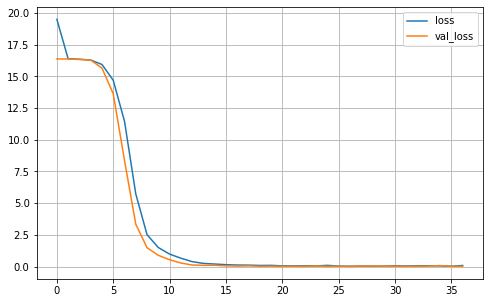

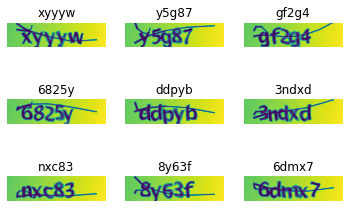

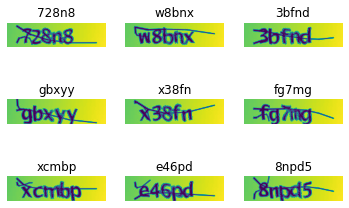

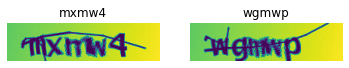

In [49]:
Evaluator = Evaluation(My_OCR)
Evaluator.evaluate_the_model()